# Monte Carlo Simulation Function

- Break down the function into parts to show that it works using the example in Longstaff Schwartz 

In [1]:
options(scipen = 999) # No scientific notation
S <- matrix(c( # Matrix of stock price paths starting at t = 1
  1.09, 1.08, 1.34,
  1.16, 1.26, 1.54,
  1.22, 1.07, 1.03,
  0.93, 0.97, 0.92,
  1.11, 1.56, 1.52,
  0.76, 0.77, 0.90,
  0.92, 0.84, 1.01,
  0.88, 1.22, 1.34
), nrow = 8, byrow = TRUE)

In [2]:
# Parameters 
K <- 1.1 # Strike Price 
M <- 3 # Number of time steps
n <- 8 # Number of paths (simulations)
dt <- 1 # Time step size
r <- 0.06 # Risk-free interest rate
discount <- round(exp(-r * dt),5) # Discount factor for one time step
print(discount)

[1] 0.94176


In [3]:
V <- pmax(K - S[, M], 0) # Get the last column of the matrix S and calculate the payoff
Cash_flow <- matrix(0, nrow = n, ncol = M) # Initialize Cash_flow matrix with zeros
Cash_flow[, M] <- V # Set the last column of Cash_flow to V
print(Cash_flow) 

for (m in M:2) { # Loop from M to 2 
  X <- S[, m-1] # Get the stock prices at time m-1
  Y <- Cash_flow[, m] * discount # Discount the cash flows at time m
  XY <- cbind(X, Y)
  XY[X > K, ] <- NA # Only consider paths where stock price is less than K (in the money), make NA so regression does not consider them
  
  # Regression model
  polynomial <- Y ~ X + I(X^2) # Choose the polynomial 
  regression <- lm(polynomial, data = as.data.frame(XY)) # Fit using X and Y 
  print(regression)  
  
  immediate_exercise <- pmax(K - S[, m-1], 0) # Calculate immediate exercise value at time m-1  
  continuation <- predict(regression, newdata = as.data.frame(X)) # Calculate continuation value for X values at time m-1 using regression model
  full_step <- cbind(XY, continuation, immediate_exercise) # Combine all matrices for this step 
  full_step[immediate_exercise == 0, ] <- NA # Exclude not in the money paths 
  print(full_step)  
  
  result_vector <- ifelse(
    is.na(full_step[, 4]), 0, # If column 4 (Immediate Exercise) is NA (not in the money paths), set to 0              
    ifelse(full_step[, 3] > full_step[, 4], 0, full_step[, 4]) # If continutation value is greater than immediate exercise, set to 0, else set to immediate exercise value
  ) 
  
  Cash_flow[, m-1] <- result_vector # Update Cash_flow matrix with the result vector for the current step
  print(Cash_flow)  
}

     [,1] [,2] [,3]
[1,]    0    0 0.00
[2,]    0    0 0.00
[3,]    0    0 0.07
[4,]    0    0 0.18
[5,]    0    0 0.00
[6,]    0    0 0.20
[7,]    0    0 0.09
[8,]    0    0 0.00

Call:
lm(formula = polynomial, data = as.data.frame(XY))

Coefficients:
(Intercept)            X       I(X^2)  
     -1.070        2.983       -1.814  

     X         Y continuation immediate_exercise
1 1.08 0.0000000   0.03674038               0.02
2   NA        NA           NA                 NA
3 1.07 0.0659232   0.04589812               0.03
4 0.97 0.1695168   0.11752626               0.13
5   NA        NA           NA                 NA
6 0.77 0.1883520   0.15196848               0.33
7 0.84 0.0847584   0.15641716               0.26
8   NA        NA           NA                 NA
     [,1] [,2] [,3]
[1,]    0 0.00 0.00
[2,]    0 0.00 0.00
[3,]    0 0.00 0.07
[4,]    0 0.13 0.18
[5,]    0 0.00 0.00
[6,]    0 0.33 0.20
[7,]    0 0.26 0.09
[8,]    0 0.00 0.00

Call:
lm(formula = polynomial, data = as.dat

In [4]:
for (i in 1:nrow(Cash_flow)) {
  for (j in 1:ncol(Cash_flow)) {
    if (Cash_flow[i, j] != 0) { # First row non-zero value
      discount <- round(exp(-r * j), 5) # Discount for number of columns (time steps)
      Cash_flow[i, j] <- Cash_flow[i, j] * discount
      if (j < ncol(Cash_flow)) {
        Cash_flow[i, (j+1):ncol(Cash_flow)] <- 0 # Zero out future columns for that row 
      }
      break  # Break loop is non-zero value is found, go to new row  
    }
  }
}
print(Cash_flow) 
print(mean(rowSums(Cash_flow))) # This gives the same result as Longstaff Schwartz 

          [,1] [,2]      [,3]
[1,] 0.0000000    0 0.0000000
[2,] 0.0000000    0 0.0000000
[3,] 0.0000000    0 0.0584689
[4,] 0.1600992    0 0.0000000
[5,] 0.0000000    0 0.0000000
[6,] 0.3201984    0 0.0000000
[7,] 0.1695168    0 0.0000000
[8,] 0.2071872    0 0.0000000


[1] 0.1144338


## American Put using OLS Function

In [5]:
price_american_put_longstaff_schwartz <- function(K, M, n, dt, r, S,polynomial) {
  discount <- exp(-r * dt)  
  
  V <- pmax(K - S[, M], 0)  
  Cash_flow <- matrix(0, nrow = n, ncol = M)
  Cash_flow[, M] <- V
  
  # Cash Flows at each time step 
  for (m in M:2) {
    X <- S[, m-1]
    Y <- Cash_flow[, m] * discount
    XY <- cbind(X, Y)
    XY[X > K, ] <- NA  
    
    regression <- lm(polynomial, data = as.data.frame(XY))
    
    immediate_exercise <- pmax(K - S[, m-1], 0)
    continuation <- predict(regression, newdata = as.data.frame(X))
    
    full_step <- cbind(continuation, immediate_exercise)
    full_step[immediate_exercise == 0, ] <- NA
    
    result_vector <- ifelse(
      is.na(full_step[, 2]), 0,                       
      ifelse(full_step[, 1] > full_step[, 2], 0, full_step[, 2])
    )
    Cash_flow[, m-1] <- result_vector
  }
  
  # Discounting 
  for (i in 1:nrow(Cash_flow)) {
    for (j in 1:ncol(Cash_flow)) {
      if (Cash_flow[i, j] != 0) { 
        Cash_flow[i, j] <- Cash_flow[i, j] * round(exp(-r * j), 5)
        if (j < ncol(Cash_flow)) {
          Cash_flow[i, (j+1):ncol(Cash_flow)] <- 0
        }
        break
      }
    }
  }
  
  option_price <- mean(rowSums(Cash_flow))
  return(option_price)
}

### Example of differing polynomial degrees

In [6]:
price_american_put_longstaff_schwartz(
  K = 1.1, 
  M = 3, 
  n = 8, 
  dt = 1, 
  r = 0.06, 
  S = S,
  polynomial = Y ~ X + I(X^2)
)

[1] 0.1144338

In [7]:
price_american_put_longstaff_schwartz(
  K = 1.1, 
  M = 3, 
  n = 8, 
  dt = 1, 
  r = 0.06, 
  S = S, 
  polynomial = Y ~ X + I(X^2) + I(X^3) + I(X^4)
)

[1] 0.1242864

## Monte Carlo American Put using OLS 
- Instead of a fixed stock path matrix we generate stock paths using Geometric Brownian Motion 

#### Visualize Geometric Brownian Motion

In [15]:
# Generate stock price paths using Geometric Brownian Motion
set.seed(123)
M <- 100
dt <- 1 / M # Time step size
N  <- 100
sigma <- 0.01026789
S0 <- 931.8
r <- 0.5290473

stock_tree <- matrix(0, nrow = N, ncol = M + 1) # Matrix to store stock prices 
stock_tree[, 1] <- S0 # Inital stock price 
for (j in 2:(M + 1)) {
    Z <- rnorm(N)
    stock_tree[, j] <- stock_tree[, j - 1] * exp((r - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z) # Postive drift
    #stock_tree[, j] <- stock_tree[, j - 1] * exp(sigma * sqrt(dt) * Z) # Without drift gives a very different plot 
  }
S <- stock_tree[,-1] # Exclude initial stock price

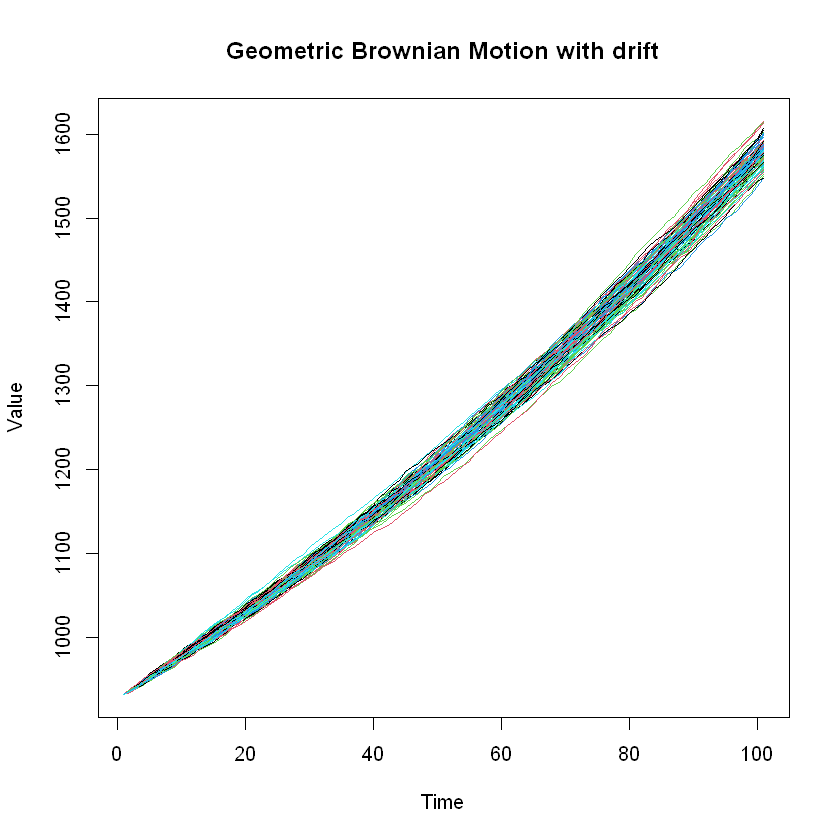

In [16]:
matplot(t(stock_tree), type = "l", lty = 1, col = 1:5,  xlab = "Time", ylab = "Value", main = "Geometric Brownian Motion with drift")

#### Function for Monte Carlo American Put
- Generate paths using Monte Carlo

In [10]:
price_american_put_longstaff_schwartz_MC <- function(K, M, N, r, S0,sigma, polynomial) {
  
  dt <- 1/M
  stock_tree <- matrix(0, nrow = N, ncol = M + 1) 
  stock_tree[, 1] <- S0
  set.seed(123)
  
  for (j in 2:(M + 1)) {
    Z <- rnorm(N)
    # stock_tree[, j] <- stock_tree[, j - 1] * exp((r - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z) # Postive drift 
    stock_tree[, j] <- stock_tree[, j - 1] * exp(sigma * sqrt(dt) * Z) # No drift 
  }
  S <- stock_tree[,-1] 
  discount <- exp(-r * dt)  
  
  V <- pmax(K - S[, M], 0)  
  Cash_flow <- matrix(0, nrow = N, ncol = M)
  Cash_flow[, M] <- V
  
  # Cash Flows at each time step 
  for (m in M:2) {
    X <- S[, m-1]
    Y <- Cash_flow[, m] * discount
    XY <- cbind(X, Y)
    XY[X > K, ] <- NA  

    if (all(is.na(XY))) {
        Cash_flow[, m-1] <- 0  # Skip regression if no in the money paths
        next
    }
    
    regression <- lm(polynomial, data = as.data.frame(XY))
    
    immediate_exercise <- pmax(K - S[, m-1], 0)
    continuation <- predict(regression, newdata = as.data.frame(X))
    
    full_step <- cbind(continuation, immediate_exercise)
    full_step[immediate_exercise == 0, ] <- NA
    
    result_vector <- ifelse(
      is.na(full_step[, 2]), 0,                       
      ifelse(full_step[, 1] > full_step[, 2], 0, full_step[, 2])
    )
    Cash_flow[, m-1] <- result_vector
  }
  
  # Discounting 
  for (i in 1:nrow(Cash_flow)) {
    for (j in 1:ncol(Cash_flow)) {
      if (Cash_flow[i, j] != 0) { 
        Cash_flow[i, j] <- Cash_flow[i, j] * round(exp(-r * j), 5)
        if (j < ncol(Cash_flow)) {
          Cash_flow[i, (j+1):ncol(Cash_flow)] <- 0
        }
        break
      }
    }
  }
  
  option_price <- mean(rowSums(Cash_flow))
  return(option_price)
}

In [11]:
# Example 1 comparison with binomial tree, slightly in the money  
price_american_put_longstaff_schwartz_MC(
  K = 940,
  M = 1000, 
  N = 10000,  
  r = 0.005290473,
  S0 = 931.8, 
  sigma = 0.01026789,
  polynomial = Y ~ X + I(X^2) 
)


[1] 8.154303

In [12]:
# Example 2 comparison with binomial tree, at the money strike 
price_american_put_longstaff_schwartz_MC(
  K = 931.8,
  M = 1000, 
  N = 10000,  
  r = 0.005290473,
  S0 = 931.8, 
  sigma = 0.01026789,
  polynomial = Y ~ X + I(X^2) 
)

[1] 0.2218324

In [13]:
# Example 3 comparison with Monte Carlo, very deep out of the money strike price
price_american_put_longstaff_schwartz_MC(
  K = 929,
  M = 1000, 
  N = 10000,  
  r = 0.005290473,
  S0 = 931.8, 
  sigma = 0.01026789,
  polynomial = Y ~ X + I(X^2) 
)

[1] 0.06864683

In [14]:
# Example 4 comparison with Monte Carlo, very deep in the money strike price
price_american_put_longstaff_schwartz_MC(
  K = 970,
  M = 1000, 
  N = 10000,  
  r = 0.005290473,
  S0 = 931.8, 
  sigma = 0.01026789,
  polynomial = Y ~ X + I(X^2) 
)

[1] 37.98866